In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import laplace
from scipy.integrate import quad
import warnings
warnings.filterwarnings("ignore")

In [95]:
# Define the PDifMP model
class PDifMPModel:
    def __init__(self, S0, mu0, sigma, lambda0, eta, delta, beta, alpha, b, T):
        self.S0 = S0
        self.mu0 = mu0
        self.sigma = sigma
        self.lambda0 = lambda0
        self.eta = eta
        self.delta = delta
        self.beta = beta
        self.alpha = alpha
        self.b = b
        self.T = T

    def jump_intensity(self, S, mu):
        # lambda function
        return self.lambda0 + self.eta * max(0, abs(S - self.delta) - self.beta)

    def drift_jump(self, S):
        # transition kernel
        loc = self.mu0 + self.alpha * (S - self.delta)
        return laplace.rvs(loc=loc, scale=self.b)

    def simulate_path(self, dt=0.01):
        np.random.seed(0)
        times = np.arange(0, self.T, dt)
        S_path = [self.S0]
        mu_path = [self.mu0]
        
        for t in times[1:]:
            S_prev = S_path[-1]
            mu_prev = mu_path[-1]
            
            # update continuous path
            dW = np.random.normal(0, np.sqrt(dt))
            S_t = S_prev * np.exp((mu_prev - 0.5 * self.sigma**2) * dt + self.sigma * dW)
            
            # Check if a jump occurs
            jump_prob = self.jump_intensity(S_prev, mu_prev) * dt
            if np.random.rand() < jump_prob:
                mu_new = self.drift_jump(S_prev)
            else:
                mu_new = mu_prev
                
            # add updated values
            S_path.append(S_t)
            mu_path.append(mu_new)
        
        return np.array(S_path), np.array(mu_path)

In [96]:
# Define LS plus PDifmp approach
class LSPlusPDifMP:
    def __init__(self, model, strike_price, r, option_type="call", num_paths=1000, dt=0.01):
        self.model = model
        self.K = strike_price
        self.r = r
        self.option_type = option_type
        self.num_paths = num_paths
        self.dt = dt
    
    def payoff(self, S):
        # calculate the option payoff
        if self.option_type == "call":
            return np.maximum(S - self.K, 0)
        else:
            return np.maximum(self.K - S, 0)

    def simulate_paths(self):
        # asset price paths
        paths = []
        for _ in range(self.num_paths):
            S_path, _ = self.model.simulate_path(self.dt)
            paths.append(S_path)
        return np.array(paths)

    def price_option(self):
        paths = self.simulate_paths()
        num_steps = paths.shape[1]
        dt = self.model.T / num_steps
        
        # discount factor
        disc = np.exp(-self.r * dt)
        cash_flows = self.payoff(paths[:, -1])
        
        #optimal exercise strategy
        for t in range(num_steps - 2, 0, -1):
            in_the_money = self.payoff(paths[:, t]) > 0
            exercise = np.zeros(len(cash_flows))
            if in_the_money.any():
                # Least squares regression
                S_t = paths[in_the_money, t]
                X = np.vstack([S_t**0, S_t, S_t**2]).T
                Y = disc * cash_flows[in_the_money]
                coeffs = np.linalg.lstsq(X, Y, rcond=None)[0]
                continuation_value = (X @ coeffs)
                
                # Determine exercise vs continuation
                immediate_exercise_value = self.payoff(S_t)
                exercise[in_the_money] = np.where(immediate_exercise_value > continuation_value, 
                                                  immediate_exercise_value, disc * cash_flows[in_the_money])
            
            cash_flows = exercise + disc * cash_flows * (exercise == 0)
        
        # Option price is the average discounted payoff
        return np.mean(cash_flows) * np.exp(-self.r * self.model.T)

In [97]:
# Only PDifMP
class OnlyPDifMP:
    def __init__(self, model, strike_price, r, option_type="call", num_paths=1000, dt=0.01):
        self.model = model
        self.K = strike_price
        self.r = r
        self.option_type = option_type
        self.num_paths = num_paths
        self.dt = dt

    def payoff(self, S):
        if self.option_type == "call":
            return np.maximum(S - self.K, 0)
        else:
            return np.maximum(self.K - S, 0)

    def price_option(self):
        payoffs = []
        for _ in range(self.num_paths):
            S_path, _ = self.model.simulate_path(self.dt)
            payoffs.append(np.max(self.payoff(S_path)) * np.exp(-self.r * self.model.T))
        
        return np.mean(payoffs)

In [98]:
#only ls
class OnlyLS:
    def __init__(self, S0, mu, sigma, strike_price, r, T, option_type="call", num_paths=1000, dt=0.01):
        self.S0 = S0
        self.mu = mu
        self.sigma = sigma
        self.K = strike_price
        self.r = r
        self.T = T
        self.option_type = option_type
        self.num_paths = num_paths
        self.dt = dt

    def payoff(self, S):
        if self.option_type == "call":
            return np.maximum(S - self.K, 0)
        else:
            return np.maximum(self.K - S, 0)

    def simulate_paths(self):
        times = np.arange(0, self.T, self.dt)
        paths = []
        for _ in range(self.num_paths):
            S_path = [self.S0]
            for t in times[1:]:
                dW = np.random.normal(0, np.sqrt(self.dt))
                S_t = S_path[-1] * np.exp((self.mu - 0.5 * self.sigma**2) * self.dt + self.sigma * dW)
                S_path.append(S_t)
            paths.append(S_path)
        return np.array(paths)

    def price_option(self):
        paths = self.simulate_paths()
        num_steps = paths.shape[1]
        dt = self.T / num_steps
        disc = np.exp(-self.r * dt)
        cash_flows = self.payoff(paths[:, -1])
        
        for t in range(num_steps - 2, 0, -1):
            S_t = paths[:, t]
            in_the_money = self.payoff(S_t) > 0
            exercise = np.zeros(len(cash_flows))
            if in_the_money.any():
                S_itm = S_t[in_the_money]
                X = np.vstack([S_itm**0, S_itm, S_itm**2]).T
                Y = disc * cash_flows[in_the_money]
                coeffs = np.linalg.lstsq(X, Y, rcond=None)[0]
                continuation_value = X @ coeffs
                immediate_exercise_value = self.payoff(S_itm)
                
                exercise[in_the_money] = np.where(immediate_exercise_value > continuation_value, 
                                                  immediate_exercise_value, disc * cash_flows[in_the_money])
            
            cash_flows = exercise + disc * cash_flows * (exercise == 0)
        
        return np.mean(cash_flows) * np.exp(-self.r * self.T)

In [99]:
# run models and compute prices
pdifmp_model = PDifMPModel(S0=36, mu0=0.06, sigma=0.2, lambda0=5, eta=0.3, delta=36, beta=0, alpha=1e-6, b=0.01, T=1)
ls_plus_pdifmp = LSPlusPDifMP(model=pdifmp_model, strike_price=40, r=0.05, option_type="call", num_paths=100, dt=0.01)
only_pdifmp = OnlyPDifMP(model=pdifmp_model, strike_price=40, r=0.05, option_type="call", num_paths=100, dt=0.01)
only_ls = OnlyLS(S0=36, mu=0.06, sigma=0.2, strike_price=40, r=0.05, T=1, option_type="call", num_paths=100, dt=0.01)

price_ls_plus_pdifmp = ls_plus_pdifmp.price_option()
price_only_pdifmp=only_pdifmp.price_option()
price_only_ls=only_ls.price_option()
print("LS Plus PDifmp:",price_ls_plus_pdifmp)
print("Only PDifmp:",price_only_pdifmp)
print("Only LS",price_only_ls)

LS Plus PDifmp: 3.580997878214312
Only PDifmp: 3.7290052105628395
Only LS 1.8165247830402882


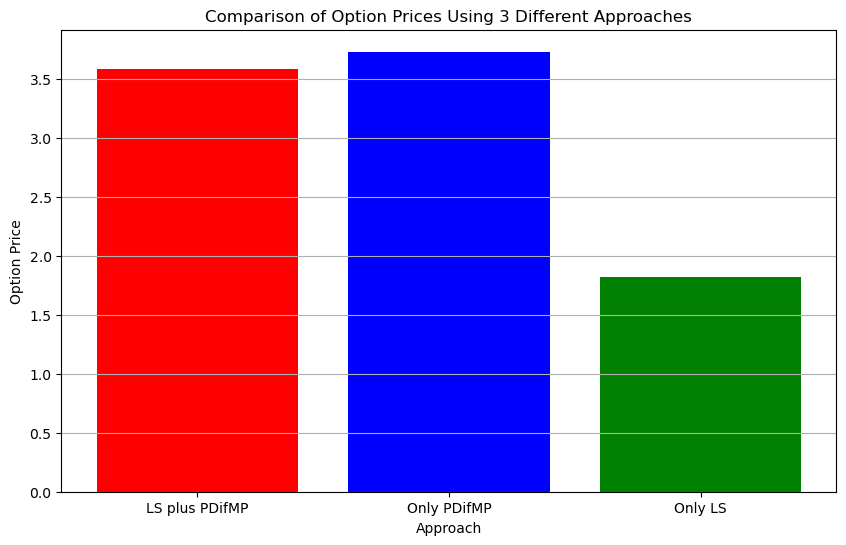

In [100]:
# Option prices from each approaches
methods = ["LS plus PDifMP", "Only PDifMP", "Only LS"]
prices = [price_ls_plus_pdifmp, price_only_pdifmp, price_only_ls]

# Plotting the comparison
plt.figure(figsize=(10, 6))
plt.bar(methods, prices, color=['red', 'blue', 'green'])
plt.title("Comparison of Option Prices Using 3 Different Approaches")
plt.xlabel("Approach")
plt.ylabel("Option Price")
plt.grid(axis='y')
plt.show()